In [12]:
# # Uncertainty Quantification for One-Step Forecasting
#
# **Dataset:** Mid-Atlantic hourly power load + temperature
# **Approaches compared:**
# 1. **Neural GARCH-style (heteroscedastic NN)** — Gaussian NLL → \(\mu_{t+1}\), \(\sigma^2_{t+1}\)
# 2. **Neural Quantile** — direct lower/upper quantiles (pinball loss)
# 3. **Bayesian (MC Dropout)** — MSE + \(\mathcal{L}_2\) at train; dropout sampling at test
#
# **Outputs:** one-step-ahead mean forecasts and 95% prediction intervals (PIs)
# **Metrics:** MAE, RMSE, empirical 95% coverage, average PI width
#
# This notebook is designed for **teaching**, with extensive comments and markdown.

## 0) Setup & Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

np.random.seed(42)
torch.manual_seed(42)

plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.grid'] = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [13]:
## 1) Load & Clean the Dataset
# We follow the exact instructions you provided.

RAW_URL = "https://raw.githubusercontent.com/vmpreciado/ESE538/main/midatlantic_august2024_combined.csv"

df = (
    pd.read_csv(RAW_URL, parse_dates=['datetime'])
    .set_index('datetime')
    .sort_index()
)

data = df.rename(columns={
    'total_power_load_MW': 'demand',
    'temperature_C': 'temp'
})[['demand', 'temp']].dropna()

display(data.head())
print("Rows:", len(data), " Range:", data.index.min(), "->", data.index.max())

,demand,temp
datetime,,
2024-08-01 00:00:00,2421894,22.9
2024-08-01 01:00:00,2322910,22.9
2024-08-01 02:00:00,2415240,22.8
2024-08-01 03:00:00,2236486,23.8
2024-08-01 04:00:00,1056416,23.8


Rows: 744  Range: 2024-08-01 00:00:00 -> 2024-08-31 23:00:00


In [14]:
## 2) Feature Engineering for One-Step Ahead Forecast
#
# We build a modest feature set that works well in practice:
# - Lags of demand (1, 2, 24, 48)
# - Hour-of-day as sin/cos seasonal features
# - Temperature and 24h moving average of temperature
# - Target is y_{t+1} = demand.shift(-1)

def make_features(df: pd.DataFrame, lags=(1, 2, 24, 48)) -> pd.DataFrame:
    out = df.copy()
    # Lags of demand
    for L in lags:
        out[f'lag_{L}'] = out['demand'].shift(L)
    # Hour-of-day Fourier features
    hod = out.index.hour
    out['sin_h'] = np.sin(2 * np.pi * hod / 24.0)
    out['cos_h'] = np.cos(2 * np.pi * hod / 24.0)
    # Temperature moving average
    out['temp_ma24'] = out['temp'].rolling(24).mean()
    # One-step-ahead target
    out['y_next'] = out['demand'].shift(-1)
    return out.dropna()


feat = make_features(data)
feat.head()

,demand,temp,lag_1,lag_2,lag_24,lag_48,sin_h,cos_h,temp_ma24,y_next
datetime,,,,,,,,,,
2024-08-03 00:00:00,2289036,22.8,2387158.0,2478084.0,2454904.0,2421894.0,0.000000,1.000000,26.150000,2197954.0
2024-08-03 01:00:00,2197954,22.8,2289036.0,2387158.0,2354856.0,2322910.0,0.258819,0.965926,26.012500,2296768.0
2024-08-03 02:00:00,2296768,22.8,2197954.0,2289036.0,2454052.0,2415240.0,0.500000,0.866025,25.945833,2138868.0
2024-08-03 03:00:00,2138868,22.2,2296768.0,2197954.0,2277220.0,2236486.0,0.707107,0.707107,25.829167,1014202.0
2024-08-03 04:00:00,1014202,21.7,2138868.0,2296768.0,1059326.0,1056416.0,0.866025,0.500000,25.645833,957314.0


In [15]:
## 3) Chronological Split & Scaling (X and y)
#
# IMPORTANT:
# - We must scale both X **and** y so the networks train at a reasonable scale.
# - After predicting, we **inverse-transform** y to the original units.
# - We respect chronological order to avoid leakage.

N = len(feat)
i_train = int(0.70 * N)
i_val = int(0.85 * N)

X_cols = [c for c in feat.columns if c not in ['y_next', 'demand']]
y_col = 'y_next'

X_train = feat.iloc[:i_train][X_cols].values
y_train = feat.iloc[:i_train][y_col].values

X_val = feat.iloc[i_train:i_val][X_cols].values
y_val = feat.iloc[i_train:i_val][y_col].values

X_test = feat.iloc[i_val:][X_cols].values
y_test = feat.iloc[i_val:][y_col].values

t_test_index = feat.iloc[i_val:].index

# Scale X with train statistics
X_scaler = StandardScaler().fit(X_train)
X_train_s = X_scaler.transform(X_train)
X_val_s = X_scaler.transform(X_val)
X_test_s = X_scaler.transform(X_test)

# Scale y with train statistics
y_scaler = StandardScaler().fit(y_train.reshape(-1, 1))
y_train_s = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_val_s = y_scaler.transform(y_val.reshape(-1, 1)).ravel()
# Do not pre-transform y_test; we only inverse-transform predictions

X_train_s.shape, X_val_s.shape, X_test_s.shape, y_train_s.shape

((486, 8), (104, 8), (105, 8), (486,))

In [16]:
## 4) PyTorch Dataset / DataLoaders

class XYDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


batch_size = 256
ds_train = XYDataset(X_train_s, y_train_s)
ds_val = XYDataset(X_val_s, y_val_s)
ds_test = XYDataset(X_test_s, np.zeros((len(X_test_s), 1)))  # y not used at test

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)

In [17]:
## 5) Model Definitions
# - A helper MLP
# - Heteroscedastic NN → outputs (mu, log_sigma2)
# - Quantile NN → outputs (q_low, q_high)
# - MC Dropout NN → outputs mean (stochastic via dropout)

def mlp(in_dim, out_dim, hidden=(128, 64), dropout=0.2, final_activation=None):
    layers = []
    d = in_dim
    for h in hidden:
        layers += [nn.Linear(d, h), nn.ReLU(), nn.Dropout(dropout)]
        d = h
    layers += [nn.Linear(d, out_dim)]
    if final_activation is not None:
        layers += [final_activation]
    return nn.Sequential(*layers)


class HeteroNN(nn.Module):
    """Backbone + two heads: mu and log variance."""

    def __init__(self, in_dim):
        super().__init__()
        self.backbone = mlp(in_dim, out_dim=64, hidden=(128, 64), dropout=0.2)
        self.mu_head = nn.Linear(64, 1)
        self.logv_head = nn.Linear(64, 1)

    def forward(self, x):
        h = self.backbone(x)
        mu = self.mu_head(h)
        logv = self.logv_head(h)
        return mu, logv


class QuantileNN(nn.Module):
    """Two-output network: lower and upper quantiles."""

    def __init__(self, in_dim):
        super().__init__()
        self.core = mlp(in_dim, out_dim=2, hidden=(128, 64), dropout=0.2)

    def forward(self, x):
        out = self.core(x)
        q_lo = out[:, 0:1]
        q_hi = out[:, 1:2]
        return q_lo, q_hi


class MCDropoutNN(nn.Module):
    """MC Dropout: keep dropout active at test time to sample predictions."""

    def __init__(self, in_dim, dropout=0.3, hidden=(128, 64)):
        super().__init__()
        self.net = mlp(in_dim, out_dim=1, hidden=hidden, dropout=dropout)

    def forward(self, x):
        return self.net(x)

In [18]:
## 6) Losses & Training Utility
# - Gaussian NLL for heteroscedastic model (in standardized y-space)
# - Pinball loss for quantiles
# - MSE for MC Dropout
# - Generic train loop with best-model restore (by val loss)

def gaussian_nll(y, mu, logv):
    # NLL = 0.5*(log(2π) + log σ^2 + (y-μ)^2 / σ^2)
    return 0.5 * (np.log(2 * np.pi) + logv + ((y - mu) ** 2) / torch.exp(logv))


def pinball_loss(y, q, tau):
    e = y - q
    return torch.maximum(tau * e, (tau - 1) * e)


def train_loop(model, dl, dl_val, optimizer, loss_fn, epochs=40, l2_lambda=0.0, verbose=True):
    model.to(device)
    best_val = np.inf
    best_state = None
    for ep in range(1, epochs + 1):
        model.train()
        tr_loss = 0.0
        for Xb, yb in dl:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model, Xb, yb)
            # Optional explicit L2 (in addition to optimizer weight_decay)
            if l2_lambda > 0:
                l2 = sum((p ** 2).sum() for p in model.parameters())
                loss = loss + l2_lambda * l2
            loss.backward()
            optimizer.step()
            tr_loss += loss.item() * len(Xb)
        tr_loss /= len(dl.dataset)

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for Xb, yb in dl_val:
                Xb, yb = Xb.to(device), yb.to(device)
                val_loss += loss_fn(model, Xb, yb).item() * len(Xb)
            val_loss /= len(dl_val.dataset)

        if verbose and (ep == 1 or ep % 5 == 0 or ep == epochs):
            print(f"Epoch {ep:03d} | train {tr_loss:.4f} | val {val_loss:.4f}")
        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)
    model.to('cpu')
    return model

In [19]:
## 7) Train the Three Models (on standardized targets)

in_dim = X_train_s.shape[1]

# 7.1 Heteroscedastic model (Neural GARCH-style)
hetero = HeteroNN(in_dim)
opt_hetero = torch.optim.Adam(hetero.parameters(), lr=1e-3, weight_decay=1e-5)


def hetero_loss_fn(model, Xb, yb):
    mu_s, logv = model(Xb)
    return gaussian_nll(yb, mu_s, logv).mean()


hetero = train_loop(hetero, dl_train, dl_val, opt_hetero, hetero_loss_fn, epochs=40)

# 7.2 Neural Quantile
quantile = QuantileNN(in_dim)
opt_quant = torch.optim.Adam(quantile.parameters(), lr=1e-3)

tau_lo, tau_hi = 0.025, 0.975
lambda_noncross = 2.0


def quantile_loss_fn(model, Xb, yb):
    q_lo_s, q_hi_s = model(Xb)
    loss_lo = pinball_loss(yb, q_lo_s, tau_lo).mean()
    loss_hi = pinball_loss(yb, q_hi_s, tau_hi).mean()
    # penalty if q_lo > q_hi
    pen = torch.relu(q_lo_s - q_hi_s).mean()
    return loss_lo + loss_hi + lambda_noncross * pen


quantile = train_loop(quantile, dl_train, dl_val, opt_quant, quantile_loss_fn, epochs=40)

# 7.3 Bayesian (MC Dropout)
mc = MCDropoutNN(in_dim, dropout=0.3)
opt_mc = torch.optim.Adam(mc.parameters(), lr=1e-3, weight_decay=1e-4)  # weight_decay ~ ridge


def mse_loss_fn(model, Xb, yb):
    yhat_s = model(Xb)
    return ((yb - yhat_s) ** 2).mean()


mc = train_loop(mc, dl_train, dl_val, opt_mc, mse_loss_fn, epochs=40)

Epoch 001 | train 1.3932 | val 1.3602
Epoch 005 | train 1.0336 | val 0.9477
Epoch 010 | train 0.6752 | val 0.4687
Epoch 015 | train 0.4684 | val 0.2817
Epoch 020 | train 0.3291 | val 0.2041
Epoch 025 | train 0.2046 | val 0.1135
Epoch 030 | train 0.2229 | val 0.0457
Epoch 035 | train 0.1113 | val 0.0255
Epoch 040 | train 0.1013 | val -0.0535
Epoch 001 | train 1.4303 | val 1.0569
Epoch 005 | train 0.6064 | val 0.6089
Epoch 010 | train 0.2472 | val 0.2351
Epoch 015 | train 0.0872 | val 0.0671
Epoch 020 | train 0.0737 | val 0.0675
Epoch 025 | train 0.0748 | val 0.0692
Epoch 030 | train 0.0701 | val 0.0655
Epoch 035 | train 0.0647 | val 0.0609
Epoch 040 | train 0.0623 | val 0.0570
Epoch 001 | train 0.8851 | val 0.7534
Epoch 005 | train 0.3376 | val 0.2699
Epoch 010 | train 0.2336 | val 0.1551
Epoch 015 | train 0.1854 | val 0.1467
Epoch 020 | train 0.1584 | val 0.1520
Epoch 025 | train 0.1612 | val 0.1189
Epoch 030 | train 0.1421 | val 0.1145
Epoch 035 | train 0.1343 | val 0.1060
Epoch 040 |

In [20]:
## 8) Inference Functions
# - IMPORTANT: We inverse-transform predictions from standardized y-space to original units.
# - MC Dropout: we keep dropout active (model.train()) to sample multiple outputs.

def predict_hetero(model, X):
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X, dtype=torch.float32)
        mu_s, logv = model(X_t)
        mu_s = mu_s.numpy().ravel()
        sigma_s = np.sqrt(np.exp(logv.numpy().ravel()))
        # inverse-transform: y = mu + sigma * z  ⇒ mean scales with std of scaler; variance multiplies by std^2
        mu = y_scaler.inverse_transform(mu_s.reshape(-1, 1)).ravel()
        # sigma in original scale:
        sigma = sigma_s * y_scaler.scale_[0]
    return mu, sigma


def predict_quantile(model, X):
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X, dtype=torch.float32)
        q_lo_s, q_hi_s = model(X_t)
        q_lo = y_scaler.inverse_transform(q_lo_s.numpy())
        q_hi = y_scaler.inverse_transform(q_hi_s.numpy())
        return q_lo.ravel(), q_hi.ravel()


def predict_mc_dropout(model, X, M=200):
    # Keep dropout active to sample different subnetworks
    model.train()
    model.to(device)
    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    preds_s = []
    with torch.no_grad():
        for _ in range(M):
            yhat_s = model(X_t).cpu().numpy().ravel()
            preds_s.append(yhat_s)
    preds_s = np.stack(preds_s, axis=0)  # (M, N)
    # Inverse transform each sample set
    preds = y_scaler.inverse_transform(preds_s.reshape(-1, 1)).reshape(preds_s.shape)
    mean_pred = preds.mean(axis=0)
    lo = np.percentile(preds, 2.5, axis=0)
    hi = np.percentile(preds, 97.5, axis=0)
    return mean_pred, lo, hi, preds

In [21]:
## 9) Predict on the Test Set & Compute Metrics

# Heteroscedastic: mean & sigma → normal PI [mu ± 1.96*sigma]
mu_h, s_h = predict_hetero(hetero, X_test_s)
lo_h = mu_h - 1.96 * s_h
hi_h = mu_h + 1.96 * s_h

# Quantile: direct PIs
qlo_q, qhi_q = predict_quantile(quantile, X_test_s)

# MC Dropout: empirical PIs
mean_mc, lo_mc, hi_mc, preds_mc = predict_mc_dropout(mc, X_test_s, M=200)


def coverage_and_width(y_true, lo, hi):
    cov = ((y_true >= lo) & (y_true <= hi)).mean()
    width = (hi - lo).mean()
    return cov, width


# Point-forecast metrics using expected means
rmse_h = np.sqrt(mean_squared_error(y_test, mu_h))
mae_h = mean_absolute_error(y_test, mu_h)

rmse_q = np.sqrt(mean_squared_error(y_test, 0.5 * (qlo_q + qhi_q)))
mae_q = mean_absolute_error(y_test, 0.5 * (qlo_q + qhi_q))

rmse_mc = np.sqrt(mean_squared_error(y_test, mean_mc))
mae_mc = mean_absolute_error(y_test, mean_mc)

cov_h, w_h = coverage_and_width(y_test, lo_h, hi_h)
cov_q, w_q = coverage_and_width(y_test, qlo_q, qhi_q)
cov_mc, w_mc = coverage_and_width(y_test, lo_mc, hi_mc)

summary = pd.DataFrame({
    'Model': ['Heteroscedastic NN', 'Neural Quantile', 'Bayesian (MC Dropout)'],
    'MAE': [mae_h, mae_q, mae_mc],
    'RMSE': [rmse_h, rmse_q, rmse_mc],
    'Coverage@95%': [cov_h, cov_q, cov_mc],
    'Avg PI Width': [w_h, w_q, w_mc]
})
summary

,Model,MAE,RMSE,Coverage@95%,Avg PI Width
0,Heteroscedastic NN,122583.189881,180936.033977,0.942857,5.902424e+05
1,Neural Quantile,314946.778571,371576.498255,1.000000,1.381408e+06
2,Bayesian (MC Dropout),129753.666071,176990.783492,0.819048,4.623763e+05


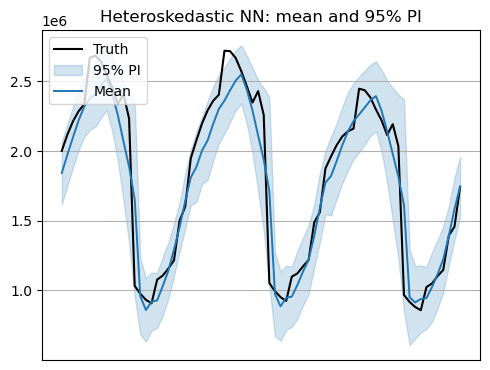

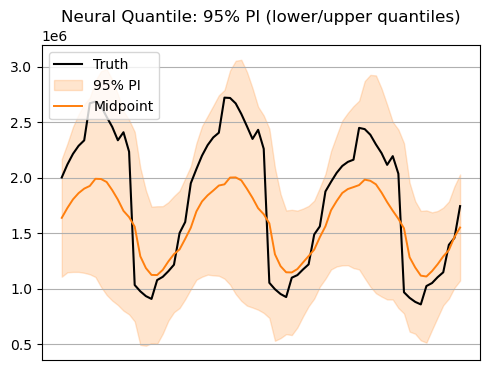

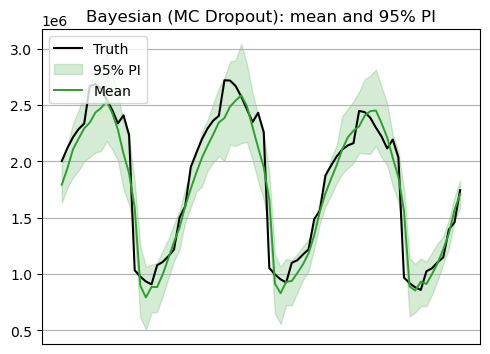

In [29]:
## 10) Visualize a Short Test Window — One Figure per Technique
# We plot the same ~3-day slice for each method to avoid crowding.

# Choose a short slice (adjust k0,k1 as you like)
k0, k1 = 0, min(24 * 3, len(y_test))
tt = t_test_index[k0:k1]
yy = y_test[k0:k1]

# ---------- 1) Heteroscedastic NN (Gaussian NLL) ----------
plt.figure(figsize=(5, 3.8))
plt.plot(tt, yy, label='Truth', color='k', lw=1.5)
plt.fill_between(tt, lo_h[k0:k1], hi_h[k0:k1],
                 color='tab:blue', alpha=0.20, label='95% PI')
plt.plot(tt, mu_h[k0:k1], color='tab:blue', lw=1.4, label='Mean')
plt.title('Heteroskedastic NN: mean and 95% PI')
plt.legend(loc='upper left')
plt.xticks([])                # remove x-axis tick labels
plt.gca().set_xlabel('')      # remove x-axis label
plt.tight_layout()
plt.show()

# ---------- 2) Neural Quantile (Pinball loss) ----------
plt.figure(figsize=(5, 3.8))
plt.plot(tt, yy, label='Truth', color='k', lw=1.5)
plt.fill_between(tt, qlo_q[k0:k1], qhi_q[k0:k1],
                 color='tab:orange', alpha=0.20, label='95% PI')
plt.plot(tt, 0.5 * (qlo_q[k0:k1] + qhi_q[k0:k1]),
         color='tab:orange', lw=1.4, label='Midpoint')
plt.title('Neural Quantile: 95% PI (lower/upper quantiles)')
plt.legend(loc='upper left')
plt.xticks([])
plt.gca().set_xlabel('')
plt.tight_layout()
plt.show()

# ---------- 3) Bayesian (MC Dropout) ----------
plt.figure(figsize=(5, 3.8))
plt.plot(tt, yy, label='Truth', color='k', lw=1.5)
plt.fill_between(tt, lo_mc[k0:k1], hi_mc[k0:k1],
                 color='tab:green', alpha=0.20, label='95% PI')
plt.plot(tt, mean_mc[k0:k1], color='tab:green', lw=1.4, label='Mean')
plt.title('Bayesian (MC Dropout): mean and 95% PI')
plt.legend(loc='upper left')
plt.xticks([])
plt.gca().set_xlabel('')
plt.tight_layout()
plt.show()

In [23]:
## 11) Sanity Checks & Notes
#
# - If any band looks flat at ~0, verify:
#   (1) y_scaler inverse-transform is applied to predictions,
#   (2) dropout is active at inference: model.train() in predict_mc_dropout,
#   (3) y_scaler.scale_ is used to rescale sigma in heteroscedastic model.
# - Try different dropout rates (0.2–0.4) or more samples (M=500) for smoother MC bands.
# - For tighter/looser bands, adjust quantile taus or z-score for hetero PI.
# - Consider PIT histograms / coverage-by-hour to diagnose calibration nuances.

# Print numbers again to ensure we see variation and reasonable scales.
print(summary)

                   Model            MAE           RMSE  Coverage@95%  \
0     Heteroscedastic NN  122583.189881  180936.033977      0.942857   
1        Neural Quantile  314946.778571  371576.498255      1.000000   
2  Bayesian (MC Dropout)  129753.666071  176990.783492      0.819048   

   Avg PI Width  
0  5.902424e+05  
1  1.381408e+06  
2  4.623763e+05  
